In [1]:
'''
This script will do the delaunay tessellation of input 3D coorinates and returns the tetrahedraliy 
histogram
usage "python PepDelaunay.py xx.pdb xx.traj up"
'''

'\nThis script will do the delaunay tessellation of input 3D coorinates and returns the tetrahedraliy \nhistogram\nusage "python PepDelaunay.py xx.pdb xx.traj up"\n'

In [2]:
import numpy as np
import numpy.linalg
import scipy.stats
import MDAnalysis as mda
import mdtraj as md
import MDAnalysis.lib.distances
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import MDAnalysis.lib.NeighborSearch as NS
from scipy.spatial import Voronoi, voronoi_plot_2d, SphericalVoronoi, Delaunay
import multiprocessing as mp
import pandas as pd
import seaborn as sns

In [3]:
def GetCoords(ts):
    timestep=200
    
    points = []
    
    RES_Sel   =ref.select_atoms('bynum '+ str(0) + ':' + str(atoms) +' and name BB' +' and resname LYS')
    num_res   =len(list(RES_Sel.residues.resnames))

    atoms3    = u.select_atoms(sel1)
    chain1    = []
    chain2    = []
    #print (sel1.positions)
    
    for tt in tqdm(u.trajectory[::timestep]):
        atom_Groups = [[] for x in range(chains)]
        m_start     = 0
        for m in range(0,chains):
            m_end   = atoms * (m+1)
            atom_Groups[m].extend([u.select_atoms('bynum '+ str(m_start) + ':' + str(m_end) +' and name BB' +' and resname LYS')]) 
            m_start = m_end + 1
            mySet   = set([])   
            
   
        for i in range(chains):
            for j in range(num_res):
                for k in range(j+3, num_res):
                    #print (i,j,k, atom_Groups[i][0].positions[j],atom_Groups[i][0].positions[k],atom_Groups[i][0].resids)
                    chain1.append(atom_Groups[i][0].positions[j])
                    chain2.append(atom_Groups[i][0].positions[k])
                    coords = np.concatenate((np.array(chain1), np.array(chain2)), axis=0) 
    return (coords)                   
                    
                    

In [4]:
def EdgeLength(A,B):
    dist=math.sqrt( ((float(A[0]) -float(B[0]))**2 ) +  ((float(A[1]) -float(B[1]))**2 ) + ((float(A[2]) -float(B[2]))**2 )   )
    return dist

In [5]:
def Delaunay_Tessellation(ts):
    print ('Frame %i in %i \n'%(ts, end_f))
    points = GetCoords(ts)
    tri    = Delaunay(points)   
    
    #plt.plot(points[:, 0], points[:, 1], points[:, 2], c='b', linestyle='dashed')
    #plt.plot(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2], c='g')
    #plt.show()
    #print ("shape", tri.simplices.shape)
    #print ("#",tri.simplices)
    #tri.simplices[0]
    #print ("#",tri.neighbors)
    #points[tri.simplices]

    ridge_points   = tri.simplices
    r_length       = len(ridge_points)
    tetrahedrality = []
    for k in range(0, r_length):
        
        sum_edge       = 0
        sumd           = 0
        tetra          = 0
        lbar           = 0
        ridge_k = ridge_points[k]
        L0 = points[int(ridge_k[0])]
        L1 = points[int(ridge_k[1])] 
        L2 = points[int(ridge_k[2])] 
        L3 = points[int(ridge_k[3])]   
        #print (ridge_k, L0, L1, L2, L3) 
        
        L01 = EdgeLength(L0,L1)
        L02 = EdgeLength(L0,L2)
        L03 = EdgeLength(L0,L3)
        L12 = EdgeLength(L1,L2)
        L13 = EdgeLength(L1,L3)
        L23 = EdgeLength(L2,L3)
        
        sumd += L01 + L02 + L03 + L12 + L13 + L23 
        lbar= sumd/15.0
        
        a1  = EdgeLength(L0,L1) - EdgeLength(L0,L2)
        a2  = EdgeLength(L0,L1) - EdgeLength(L0,L3)
        a3  = EdgeLength(L0,L1) - EdgeLength(L1,L2)
        a4  = EdgeLength(L0,L1) - EdgeLength(L1,L3)
        a5  = EdgeLength(L0,L1) - EdgeLength(L2,L3)
        
        a6  = EdgeLength(L0,L2) - EdgeLength(L0,L3)
        a7  = EdgeLength(L0,L2) - EdgeLength(L1,L2)
        a8  = EdgeLength(L0,L2) - EdgeLength(L1,L3)
        a9  = EdgeLength(L0,L2) - EdgeLength(L2,L3)
        
        a10 = EdgeLength(L0,L3) - EdgeLength(L1,L2)
        a11 = EdgeLength(L0,L3) - EdgeLength(L1,L2)
        a12 = EdgeLength(L0,L3) - EdgeLength(L1,L2)
        
        a13 = EdgeLength(L1,L2) - EdgeLength(L1,L3)
        a14 = EdgeLength(L1,L2) - EdgeLength(L2,L3)
        
        a15 = EdgeLength(L1,L3) - EdgeLength(L2,L3)
        
        
        sum_edge += a1*a1 + a2*a2 + a3*a3 + a4*a4 + a5*a5 + a6*a6 + a7*a7 + a8*a8 + a9*a9 + a10*a10  + a11*a11 + a12*a12 + a13*a13 + a14*a14 + a15*a15    
        
        tetra = sum_edge/(15*lbar*lbar) 
        #print ("lbar", lbar, "sumd", sumd, "sum_edge", sum_edge, "tet", tetra)
        tetrahedrality.append(tetra) 
        
    return (tetrahedrality)

In [6]:
def Histogram(data):
    mat   = np.asarray(pd.DataFrame(data)).flatten()
    mat1  = mat[np.logical_not(np.isnan(mat))]
    
    np.savetxt(Name+'_Tetrahedrality.dat', mat1, header=Name)
    
    ax    = sns.distplot(mat1, hist=True, kde=True, color="r", label=Name, hist_kws={ "alpha":1, "linewidth": 3})
    ax.set_ylabel("Probability")
    ax.set_xlabel("T")
    ax.set_title("Tetrahedrality", fontsize='large')
    ax.legend()
    plt.savefig(Name+"_Tetrahedrality.png", dpi=600, facecolor='w', edgecolor='w',orientation='portrait')   
    #plt.show()

/home/yadav129/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


There are 16 chains and each has 50 number of AminoAcids
Frame 1400 in 20001 
Frame 0 in 20001 
Frame 2800 in 20001 
Frame 4200 in 20001 






  0%|                                                                                                                    | 0/101 [00:00<?, ?it/s]

Initiating multiprocessing with 4 processors


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.48it/s]


Frame 200 in 20001 



  0%|                                                                                                                    | 0/101 [00:00<?, ?it/s]

Frame 1600 in 20001 



  5%|█████▎                                                                                                      | 5/101 [00:00<00:02, 39.69it/s]

Frame 4400 in 20001 



 17%|██████████████████                                                                                         | 17/101 [00:00<00:04, 20.63it/s]

Frame 3000 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  7.06it/s]


Frame 4600 in 20001 



  8%|████████▌                                                                                                   | 8/101 [00:00<00:03, 26.86it/s]

Frame 1800 in 20001 



  4%|████▎                                                                                                       | 4/101 [00:00<00:02, 33.53it/s]

Frame 400 in 20001 



 24%|█████████████████████████▍                                                                                 | 24/101 [00:01<00:04, 16.23it/s]

Frame 3200 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.67it/s]


Frame 4800 in 20001 



  8%|████████▌                                                                                                   | 8/101 [00:00<00:03, 23.67it/s]

Frame 3400 in 20001 


 11%|███████████▋                                                                                               | 11/101 [00:00<00:04, 20.41it/s]

  4%|████▎                                                                                                       | 4/101 [00:00<00:02, 34.87it/s]

Frame 600 in 20001 



  0%|                                                                                                                    | 0/101 [00:00<?, ?it/s]

Frame 2000 in 20001 


 14%|██████████████▊                                                                                            | 14/101 [00:00<00:04, 19.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.53it/s]


Frame 3600 in 20001 



  5%|█████▎                                                                                                      | 5/101 [00:00<00:02, 38.69it/s]

Frame 2200 in 20001 

Frame 800 in 20001 


  0%|                                                                                                                    | 0/101 [00:00<?, ?it/s]

  4%|████▎                                                                                                       | 4/101 [00:00<00:02, 38.75it/s]

Frame 5000 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.94it/s]


Frame 1000 in 20001 



 10%|██████████▌                                                                                                | 10/101 [00:00<00:02, 35.06it/s]

Frame 2400 in 20001 



 24%|█████████████████████████▍                                                                                 | 24/101 [00:01<00:04, 17.34it/s]

Frame 3800 in 20001 



 36%|██████████████████████████████████████▏                                                                    | 36/101 [00:01<00:04, 13.14it/s]

Frame 5200 in 20001 


 12%|████████████▋                                                                                              | 12/101 [00:00<00:03, 25.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  7.15it/s]


Frame 1200 in 20001 



 22%|███████████████████████▎                                                                                   | 22/101 [00:00<00:03, 21.14it/s]

Frame 2600 in 20001 



 14%|██████████████▊                                                                                            | 14/101 [00:00<00:03, 22.73it/s]

Frame 5400 in 20001 



 33%|██████████████████████████████████▉                                                                        | 33/101 [00:01<00:04, 14.96it/s]

Frame 4000 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.88it/s]


Frame 5600 in 20001 



 32%|█████████████████████████████████▉                                                                         | 32/101 [00:01<00:05, 13.15it/s]

Frame 7000 in 20001 



 46%|████████████████████████████████████████████████▋                                                          | 46/101 [00:03<00:05, 10.55it/s]

Frame 8400 in 20001 



  0%|                                                                                                                    | 0/101 [00:00<?, ?it/s]

Frame 9800 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.98it/s]



Frame 5800 in 20001 



 30%|███████████████████████████████▊                                                                           | 30/101 [00:01<00:04, 14.22it/s]

Frame 7200 in 20001 



 39%|█████████████████████████████████████████▎                                                                 | 39/101 [00:02<00:04, 12.97it/s]

Frame 10000 in 20001 
Frame 8600 in 20001 




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:13<00:00,  7.26it/s]


Frame 6000 in 20001 



 43%|█████████████████████████████████████████████▌                                                             | 43/101 [00:02<00:05, 10.00it/s]

Frame 7400 in 20001 



 50%|████████████████████████████████████████████████████▉                                                      | 50/101 [00:03<00:06,  7.90it/s]

Frame 10200 in 20001 



 28%|█████████████████████████████▋                                                                             | 28/101 [00:01<00:04, 15.41it/s]

Frame 8800 in 20001 


 54%|██████████████████████████████████████████████████████████▎                                                | 55/101 [00:04<00:06,  7.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.93it/s]


Frame 6200 in 20001 



 34%|████████████████████████████████████                                                                       | 34/101 [00:01<00:04, 13.49it/s]

Frame 7600 in 20001 



 22%|███████████████████████▎                                                                                   | 22/101 [00:01<00:04, 17.92it/s]

Frame 9000 in 20001 



 50%|████████████████████████████████████████████████████▉                                                      | 50/101 [00:03<00:05,  8.70it/s]

Frame 10400 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  7.02it/s]


Frame 6400 in 20001 



 40%|██████████████████████████████████████████▍                                                                | 40/101 [00:02<00:05, 11.39it/s]

Frame 7800 in 20001 



 23%|████████████████████████▎                                                                                  | 23/101 [00:01<00:04, 16.79it/s]

Frame 10600 in 20001 



  0%|                                                                                                                    | 0/101 [00:00<?, ?it/s]

Frame 9200 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.74it/s]


Frame 6600 in 20001 



 48%|██████████████████████████████████████████████████▊                                                        | 48/101 [00:03<00:05,  9.28it/s]

Frame 8000 in 20001 



 52%|████████████████████████████████████████████████████████▏                                                  | 53/101 [00:03<00:05,  9.42it/s]

Frame 10800 in 20001 



 23%|████████████████████████▎                                                                                  | 23/101 [00:01<00:03, 19.95it/s]

Frame 9400 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  7.17it/s]


Frame 6800 in 20001 



 55%|███████████████████████████████████████████████████████████▎                                               | 56/101 [00:04<00:05,  8.93it/s]

Frame 11000 in 20001 



 14%|██████████████▊                                                                                            | 14/101 [00:00<00:03, 22.65it/s]

Frame 8200 in 20001 



 63%|███████████████████████████████████████████████████████████████████▊                                       | 64/101 [00:05<00:05,  6.59it/s]

Frame 9600 in 20001 



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/101 [00:14<00:00,  3.53it/s]

Frame 11200 in 20001 



 60%|████████████████████████████████████████████████████████████████▌                                          | 61/101 [00:04<00:05,  7.11it/s]

Frame 12600 in 20001 



  4%|████▎                                                                                                       | 4/101 [00:00<00:02, 33.42it/s]

Frame 14000 in 20001 



 66%|██████████████████████████████████████████████████████████████████████▉                                    | 67/101 [00:05<00:05,  6.60it/s]

Frame 15400 in 20001 



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 98/101 [00:13<00:00,  3.47it/s]

Frame 11400 in 20001 


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/101 [00:13<00:00,  3.71it/s]

 56%|████████████████████████████████████████████████████████████▍                                              | 57/101 [00:04<00:06,  6.80it/s]

Frame 14200 in 20001 



 59%|███████████████████████████████████████████████████████████████▌                                           | 60/101 [00:05<00:06,  6.44it/s]

Frame 12800 in 20001 



 20%|█████████████████████▏                                                                                     | 20/101 [00:00<00:04, 18.62it/s]

Frame 15600 in 20001 



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/101 [00:14<00:00,  3.76it/s]

Frame 11600 in 20001 



 62%|██████████████████████████████████████████████████████████████████▋                                        | 63/101 [00:05<00:05,  7.12it/s]

Frame 15800 in 20001 



 66%|██████████████████████████████████████████████████████████████████████▉                                    | 67/101 [00:06<00:05,  5.86it/s]

Frame 14400 in 20001 



  6%|██████▍                                                                                                     | 6/101 [00:00<00:03, 27.62it/s]

Frame 13000 in 20001 



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 96/101 [00:13<00:01,  4.10it/s]

Frame 11800 in 20001 



 57%|█████████████████████████████████████████████████████████████▍                                             | 58/101 [00:04<00:06,  7.05it/s]

Frame 16000 in 20001 



 24%|█████████████████████████▍                                                                                 | 24/101 [00:01<00:04, 16.23it/s]

Frame 14600 in 20001 



  5%|█████▎                                                                                                      | 5/101 [00:00<00:02, 39.82it/s]

Frame 13200 in 20001 



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 97/101 [00:13<00:00,  4.20it/s]

Frame 12000 in 20001 



 60%|████████████████████████████████████████████████████████████████▌                                          | 61/101 [00:05<00:06,  6.66it/s]

Frame 16200 in 20001 



 11%|███████████▋                                                                                               | 11/101 [00:00<00:03, 27.64it/s]

Frame 13400 in 20001 



 17%|██████████████████                                                                                         | 17/101 [00:00<00:03, 21.35it/s]

Frame 14800 in 20001 



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 94/101 [00:12<00:01,  4.11it/s]

Frame 12200 in 20001 



 61%|█████████████████████████████████████████████████████████████████▋                                         | 62/101 [00:04<00:04,  7.85it/s]

Frame 16400 in 20001 



 20%|█████████████████████▏                                                                                     | 20/101 [00:00<00:04, 18.35it/s]

Frame 13600 in 20001 



 28%|█████████████████████████████▋                                                                             | 28/101 [00:01<00:04, 15.11it/s]

Frame 15000 in 20001 



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/101 [00:13<00:00,  3.67it/s]

Frame 12400 in 20001 



 58%|██████████████████████████████████████████████████████████████▌                                            | 59/101 [00:04<00:06,  6.52it/s]

Frame 16600 in 20001 



 30%|███████████████████████████████▊                                                                           | 30/101 [00:01<00:05, 13.90it/s]

Frame 13800 in 20001 



 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 74/101 [00:07<00:04,  5.68it/s]

Frame 15200 in 20001 



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 93/101 [00:11<00:02,  3.65it/s]

Frame 16800 in 20001 



 59%|███████████████████████████████████████████████████████████████▌                                           | 60/101 [00:05<00:06,  6.49it/s]

Frame 18200 in 20001 



 63%|███████████████████████████████████████████████████████████████████▊                                       | 64/101 [00:05<00:05,  6.47it/s]

Frame 19600 in 20001 



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 97/101 [00:11<00:00,  4.59it/s]

Frame 17000 in 20001 



 62%|██████████████████████████████████████████████████████████████████▋                                        | 63/101 [00:05<00:06,  6.32it/s]

Frame 18400 in 20001 



 20%|█████████████████████▏                                                                                     | 20/101 [00:00<00:03, 21.24it/s]

Frame 19800 in 20001 



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 93/101 [00:11<00:01,  4.13it/s]

Frame 17200 in 20001 



 52%|████████████████████████████████████████████████████████▏                                                  | 53/101 [00:03<00:04,  9.78it/s]

Frame 18600 in 20001 



 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 73/101 [00:06<00:04,  6.11it/s]

Frame 20000 in 20001 



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/101 [00:13<00:00,  4.81it/s]

Frame 17400 in 20001 



 58%|██████████████████████████████████████████████████████████████▌                                            | 59/101 [00:04<00:04, 10.31it/s]

Frame 18800 in 20001 



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 97/101 [00:10<00:00,  5.67it/s]

Frame 17600 in 20001 



 58%|██████████████████████████████████████████████████████████████▌                                            | 59/101 [00:04<00:05,  8.08it/s]

Frame 19000 in 20001 



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 98/101 [00:10<00:00,  6.00it/s]

Frame 17800 in 20001 



 60%|████████████████████████████████████████████████████████████████▌                                          | 61/101 [00:03<00:04,  9.45it/s]

Frame 19200 in 20001 



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 96/101 [00:10<00:00,  5.61it/s]

Frame 18000 in 20001 



 61%|█████████████████████████████████████████████████████████████████▋                                         | 62/101 [00:04<00:04,  8.95it/s]

Frame 19400 in 20001 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:11<00:00,  8.90it/s]
/home/yadav129/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


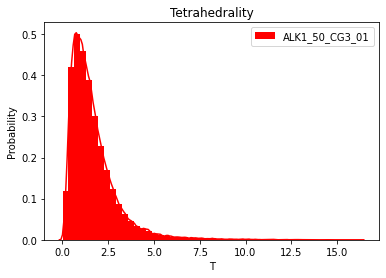

In [7]:
if __name__      ==  "__main__":
   
    ref_structure="ALK1_50_CG3_01_npt_eq.pdb"
    traj         ="ALK1_50_CG3_01_protein_final.xtc"
    Name         ='ALK1_50_CG3_01'
    
    u            = mda.Universe(ref_structure,traj)
    ref          = mda.Universe(ref_structure)
    #frames       = len(u.trajectory)
    
    topology     = md.load(ref_structure).topology
    trajectory   = md.load(traj, top=ref_structure)
    frames       = trajectory.n_frames #Number of frames
    chains       = topology.n_chains   #Number of chains
    atoms        = int(topology.n_atoms/chains)#Number of atoms in each monomer 
    AminoAcids   = int(topology.n_residues/chains) #Number of residues per chain 
    
    res          = 'LYS'    
    sel1         = 'resname %s and name BB'%res

    print ("There are {} chains and each has {} number of AminoAcids".format(AminoAcids,chains))
    
    
    start_f      = 0
    skip         = 200
    end_f        = frames  
    nprocs       = 4
    n_frames     = np.arange(start_f, end_f)[::skip]
    pool         = mp.Pool(processes=nprocs)
    
    print ('Initiating multiprocessing with %i processors'%nprocs)
    
    Tetra        = pool.map(Delaunay_Tessellation,n_frames) 
    Histogram(Tetra)    

 atom_Groups[i][0].positions[j],atom_Groups[i][0].positions[k],atom_Groups[i][0].resids)
                    chain1.append(atom_Groups[i][0].positions[j])
                    chain2.append(atom_Groups[i][0].positions[k])
                    coords = np.concatenate((np.array(chain1), np.array(chain2)), axis=0) 
                    print (coords)